### <span style = 'color:blue'> TimeSeries</span>
#### <span style = 'color:blue'>Use any forecasting method to predict Footfalls from the given dataset  </span>

For Data set please click here <a href="https://drive.google.com/file/d/1zlhACuGnjEuQCuv1Znk2yh1zcbS1wXDs/view?usp=sharing" title="Google Drive">Click here</a>

The given data is about Footfaals and we have 158 rows and here we have foot falls from 1709 to 2132 
here we have time interval as months
predict the data using any forecasting method for next 10 footfalls values

**data should 70% for training and 30% testing**

**Expected results**

- **check for dicky fuller test, rolling mean and stationarity**
- **obtain scores and interpret it**
- **predict the data or plot the graph that can plot predicted data with actual data**

In [2]:
# Importing relevant libraries

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                   # some useful functions
from tqdm import tqdm_notebook



%matplotlib inline

In [4]:
# Importing the dataset
data = pd.read_csv('footfalls.csv')

In [5]:
# Checking out the top 5 and bottom 5 records of the data
data.head()

,Month,Footfalls,t,log_footfalls,t_square,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,Jan-91,1709,1,7.443664,1,1,0,0,0,0,0,0,0,0,0,0,0
1,Feb-91,1621,2,7.390799,4,0,1,0,0,0,0,0,0,0,0,0,0
2,Mar-91,1973,3,7.587311,9,0,0,1,0,0,0,0,0,0,0,0,0
3,Apr-91,1812,4,7.502186,16,0,0,0,1,0,0,0,0,0,0,0,0
4,May-91,1975,5,7.588324,25,0,0,0,0,1,0,0,0,0,0,0,0


In [6]:
data.tail()

,Month,Footfalls,t,log_footfalls,t_square,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
154,Nov-03,2076,155,7.638198,24025,0,0,0,0,0,0,0,0,0,0,1,0
155,Dec-03,2141,156,7.669028,24336,0,0,0,0,0,0,0,0,0,0,0,1
156,Jan-04,1832,157,7.513164,24649,1,0,0,0,0,0,0,0,0,0,0,0
157,Feb-04,1838,158,7.516433,24964,0,1,0,0,0,0,0,0,0,0,0,0
158,Mar-04,2132,159,7.664816,25281,0,0,1,0,0,0,0,0,0,0,0,0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Month          159 non-null    object 
 1   Footfalls      159 non-null    int64  
 2   t              159 non-null    int64  
 3   log_footfalls  159 non-null    float64
 4   t_square       159 non-null    int64  
 5   Jan            159 non-null    int64  
 6   Feb            159 non-null    int64  
 7   Mar            159 non-null    int64  
 8   Apr            159 non-null    int64  
 9   May            159 non-null    int64  
 10  Jun            159 non-null    int64  
 11  Jul            159 non-null    int64  
 12  Aug            159 non-null    int64  
 13  Sep            159 non-null    int64  
 14  Oct            159 non-null    int64  
 15  Nov            159 non-null    int64  
 16  Dec            159 non-null    int64  
dtypes: float64(1), int64(15), object(1)
memory usage: 21.2

The month feature has object datatype must convert to a datetime datatype.

In [8]:
data['Month'] = pd.to_datetime(data['Month'], format = '%b-%y')

In [9]:
data['Month'].dtype

dtype('<M8[ns]')

###The data contains a particular month and number of customers visiting store .The data type here is object (month). Let’s convert it into a Time series object and use the Month column as our index.

In [10]:
data.set_index('Month', inplace=True)

In [12]:
#convert to time series:
ts = data['Footfalls']
ts.head(10)

Month
1991-01-01    1709
1991-02-01    1621
1991-03-01    1973
1991-04-01    1812
1991-05-01    1975
1991-06-01    1862
1991-07-01    1940
1991-08-01    2013
1991-09-01    1596
1991-10-01    1725
Name: Footfalls, dtype: int64

# <u><b>STATIONARITY</b></u>
###This is a very important concept in Time Series Analysis. In order to apply a time series model, it is important for the Time series to be stationary; in other words all its statistical properties (mean,variance) remain constant over time. This is done basically because if you take a certain behavior over time, it is important that this behavior is same in the future in order for us to forecast the series.
###In practice we can assume the series to be stationary if it has constant statistical properties over time and these properties can be:
1. constant mean
2. constant variance
3. an auto co-variance that does not depend on time.

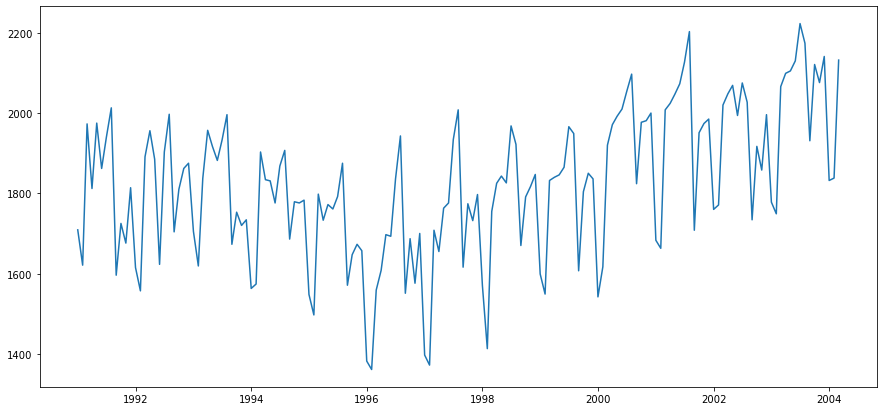

In [13]:
plt.figure(figsize=(15,7))
plt.plot(ts)

###It’s clear from the plot that there is an overall increase in the trend,with some seasonality in it.

###Plotting Rolling Statistics :We write a function which will plot the moving mean or moving Standard Deviation. This is still visual method
###Dickey-fuller Test :This is one of the statistical tests for checking stationarity. First we consider the null hypothesis: the time series is non- stationary. The result from the test will contain the test statistic and critical value for different confidence levels. The idea is to have Test statistics less than critical value, in this case we can reject the null hypothesis and say that this Time series is indeed stationary.
###We use the Augmented Dickey Fuller Test for the purpose.

In [16]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    #Plot rolling statistics:
    #timeseries
    orig = plt.plot(timeseries, color='blue',label='Original')
    #mean
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    #std-dev
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

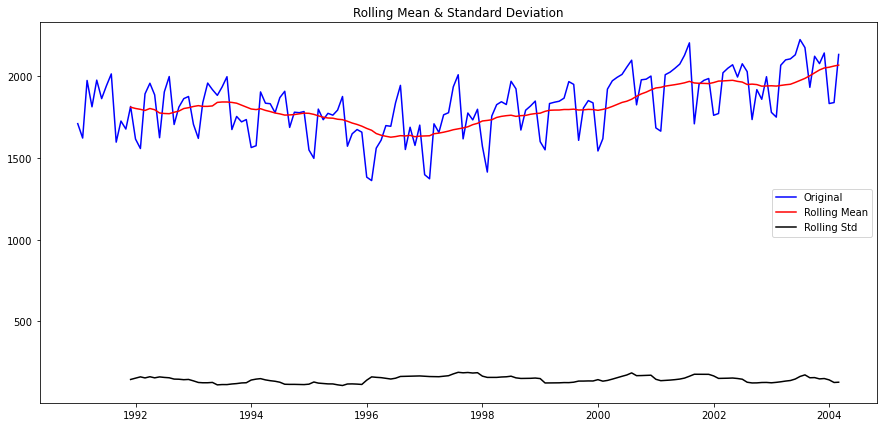

Results of Dickey-Fuller Test:
Test Statistic                  -0.234991
p-value                          0.934220
#Lags Used                      14.000000
Number of Observations Used    144.000000
Critical Value (1%)             -3.476598
Critical Value (5%)             -2.881829
Critical Value (10%)            -2.577589
dtype: float64


In [17]:
plt.figure(figsize=(15,7))
test_stationarity(ts)

###This is not stationary because :
1. mean is increasing even though the std is small.
2. Test stat is > critical value.

# <u><b>MAKING THE TIME SERIES STATIONARY</b></u>

There are two major factors that make a time series non-stationary. They are:
1. Trend: non-constant mean
2. Seasonality: Variation at specific time-frames

###The basic idea is to model the trend and seasonality in this series, so we can remove it and make the series stationary. Then we can go ahead and apply statistical forecasting to the stationary series. And finally we can convert the forecasted values into original by applying the trend and seasonality constrains back to those that we previously separated.

# <u><b>Trend</b></u>
###The first step is to reduce the trend using transformation, as we can see here that there is a strong positive trend. In this case we will use the logarithmic transformation.


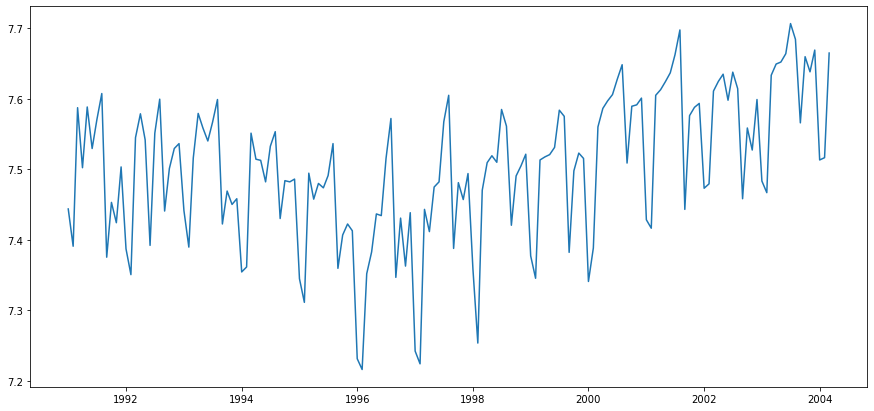

In [18]:
ts_log = np.log(ts)
plt.figure(figsize=(15,7))
plt.plot(ts_log)

# <u><b>Smoothing</b></u>
###There is some noise in realizing the forward trend here. Smoothing helps to model these trends and then remove them from the series. In smoothing we usually take the past few instances (rolling estimates)
###Moving average - First take x consecutive values and this depends on the frequency if it is 1 year we take 12 values.

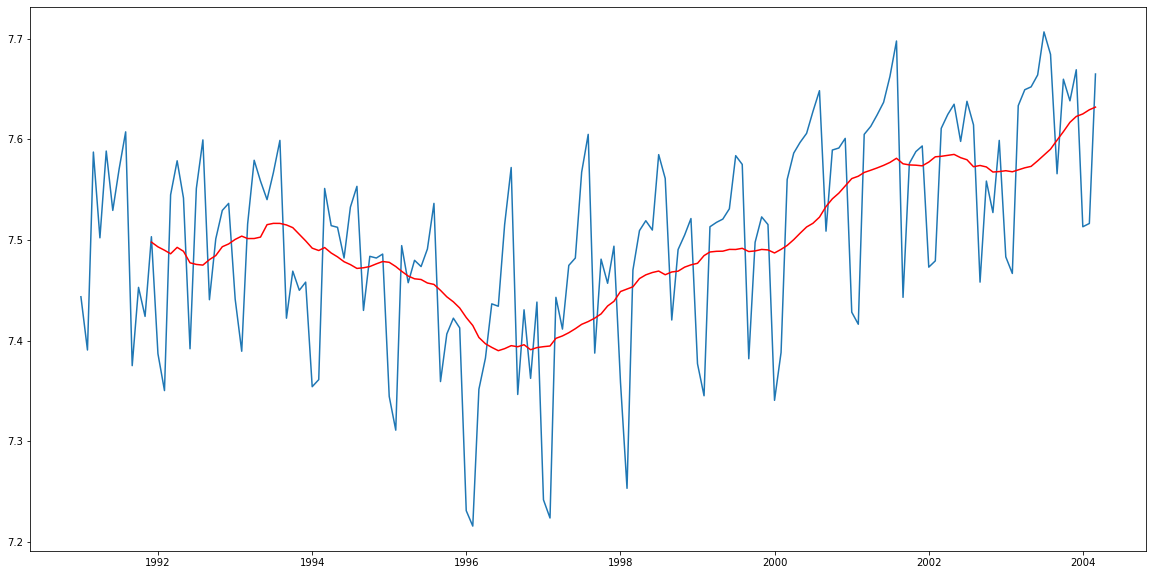

In [19]:
moving_avg = pd.Series(ts_log).rolling(12).mean()
plt.figure(figsize=(20,10))
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

###Now subtract the rolling mean from the original series.

In [20]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.tail(12)

Month
2003-04-01    0.077530
2003-05-01    0.078947
2003-06-01    0.085255
2003-07-01    0.122249
2003-08-01    0.094126
2003-09-01   -0.033372
2003-10-01    0.052051
2003-11-01    0.021361
2003-12-01    0.046347
2004-01-01   -0.112011
2004-02-01   -0.112878
2004-03-01    0.032884
Name: Footfalls, dtype: float64

In [21]:
ts_log_moving_avg_diff.dropna(inplace=True)
ts_log_moving_avg_diff.head()

Month
1991-12-01    0.005356
1992-01-01   -0.106129
1992-02-01   -0.139346
1992-03-01    0.058536
1992-04-01    0.085959
Name: Footfalls, dtype: float64

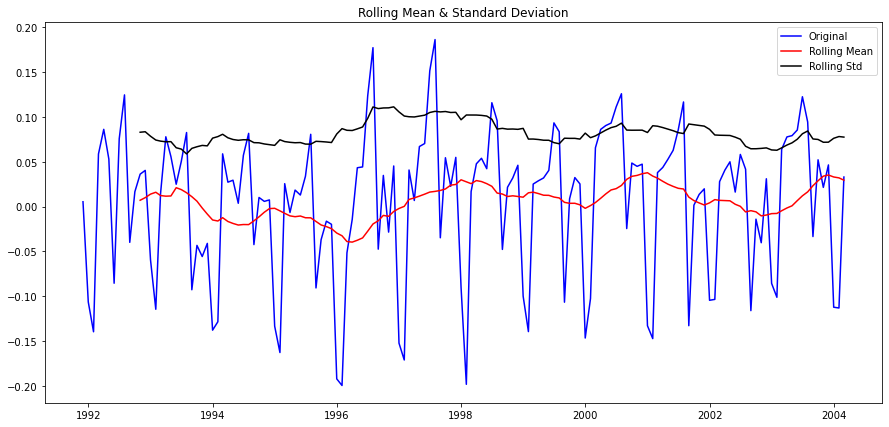

Results of Dickey-Fuller Test:
Test Statistic                  -2.877195
p-value                          0.048065
#Lags Used                      14.000000
Number of Observations Used    133.000000
Critical Value (1%)             -3.480500
Critical Value (5%)             -2.883528
Critical Value (10%)            -2.578496
dtype: float64


In [22]:
plt.figure(figsize=(15,7))
test_stationarity(ts_log_moving_avg_diff)

###We notice two things:
1. The rolling values are varying slightly but there is no specific trend.
2. The test statistics is smaller than the 10 % critical values. That tells us that we are 90% confident that this series is stationary.

###Now lets use exponentially weighted moving average for the same.

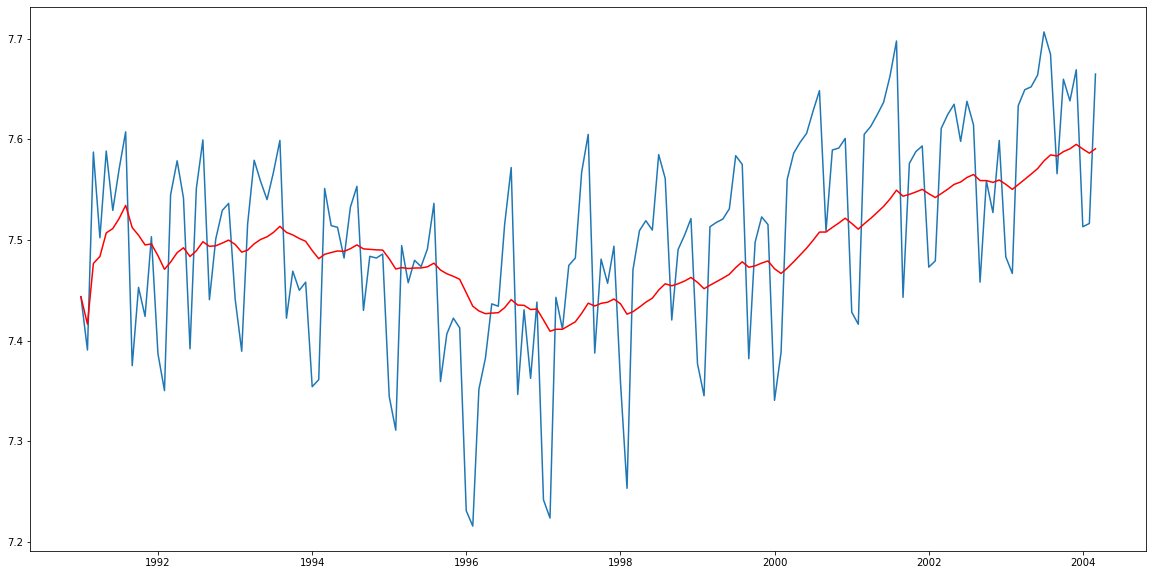

In [23]:
expwighted_avg = ts_log.ewm(halflife=12).mean()

plt.figure(figsize=(20,10))
plt.plot(ts_log)
plt.plot(expwighted_avg,color='red')

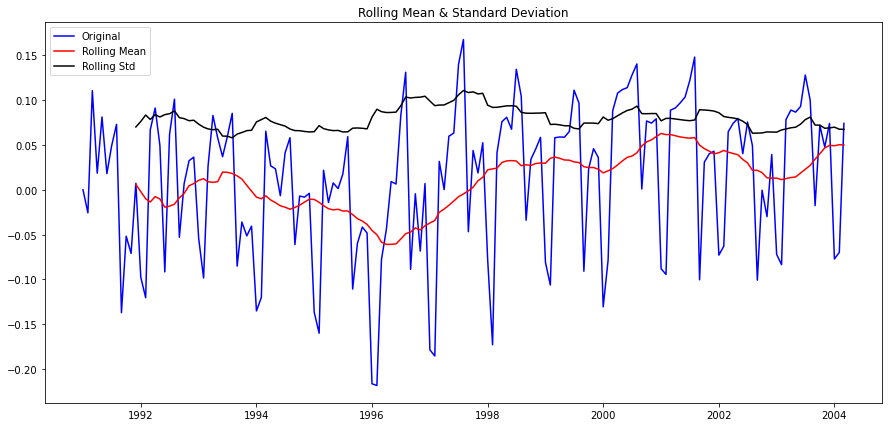

Results of Dickey-Fuller Test:
Test Statistic                  -1.733064
p-value                          0.414162
#Lags Used                      14.000000
Number of Observations Used    144.000000
Critical Value (1%)             -3.476598
Critical Value (5%)             -2.881829
Critical Value (10%)            -2.577589
dtype: float64


In [35]:
ts_log_ewma_diff = ts_log - expwighted_avg
plt.figure(figsize=(15,7))
test_stationarity(ts_log_ewma_diff)

###It is stationary because:
1. Rolling values have less variations in mean and standard deviation in magnitude.
2. the test statistic is smaller than 1% of the critical value. So we can say we are almost 99% confident that this is stationary.

# <u><b>Seasonality with Trend</b></u>
###Previously we saw just trend part of the time series, now we will see both trend and seasonality. Most Time series have trends along with seasonality.

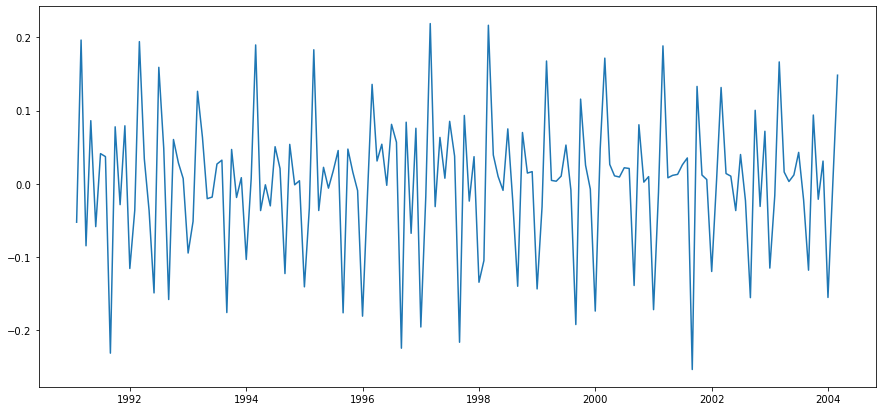

In [36]:
#Take first difference: Difference of current time value and previous time value. 
ts_log_diff = ts_log - ts_log.shift()
plt.figure(figsize=(15,7))
plt.plot(ts_log_diff)

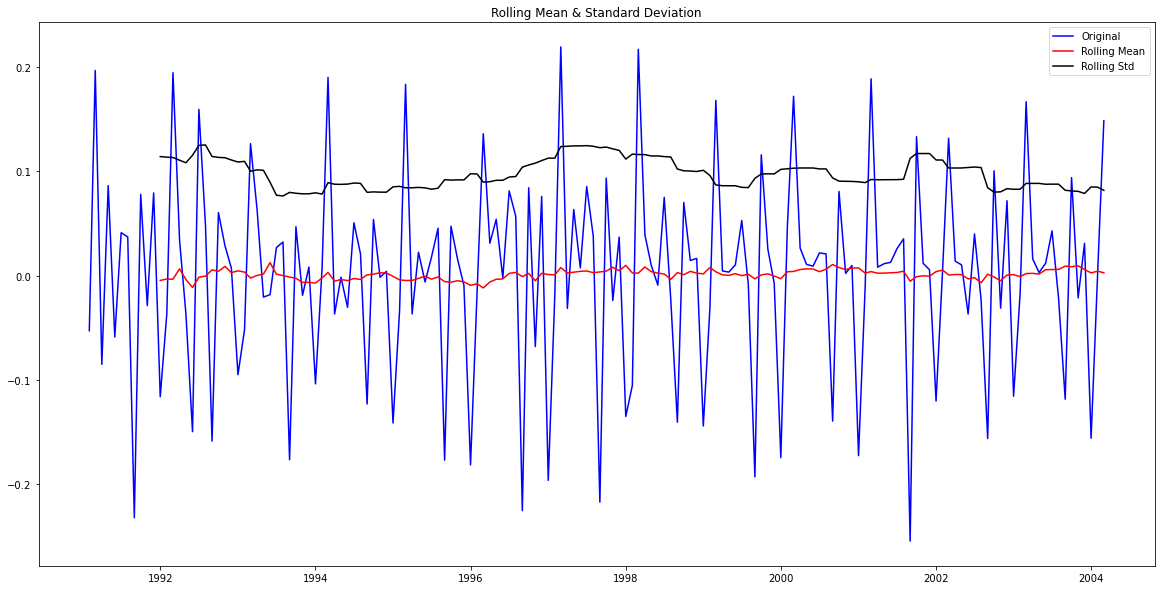

Results of Dickey-Fuller Test:
Test Statistic                  -3.325150
p-value                          0.013791
#Lags Used                      13.000000
Number of Observations Used    144.000000
Critical Value (1%)             -3.476598
Critical Value (5%)             -2.881829
Critical Value (10%)            -2.577589
dtype: float64


In [37]:
ts_log_diff.dropna(inplace=True)
plt.figure(figsize=(20,10))
test_stationarity(ts_log_diff)

# <u><b>Forecasting a Time Series</b></u>
###Auto Regressive Integrated Moving Average(ARIMA) — It is like a liner regression equation where the predictors depend on parameters (p,d,q) of the ARIMA model .
1. p : This is the number of AR (Auto-Regressive) terms . Example — if p is 3 the predictor for y(t) will be y(t-1),y(t-2),y(t-3).
2. q : This is the number of MA (Moving-Average) terms . Example — if p is 3 the predictor for y(t) will be y(t-1),y(t-2),y(t-3).
3. d :This is the number of differences or the number of non-seasonal differences.


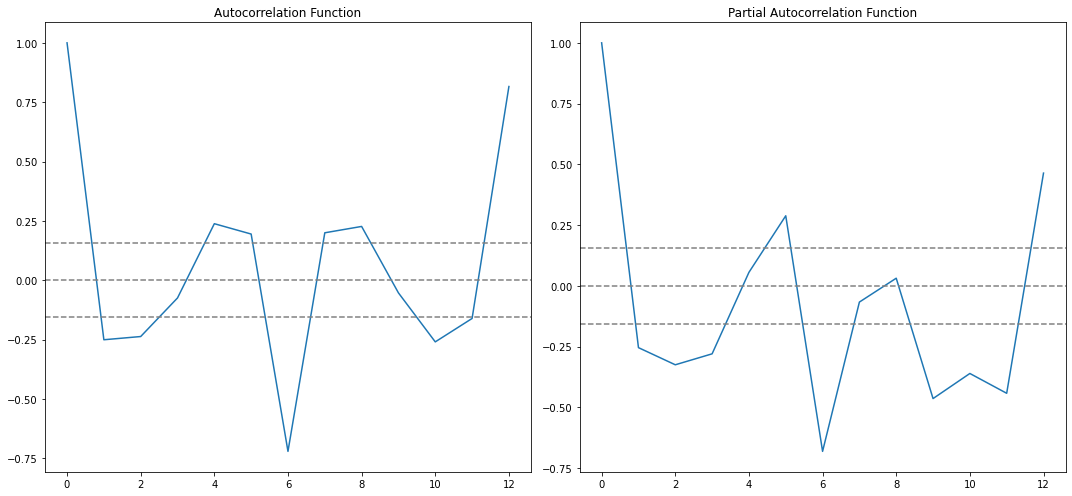

In [38]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMA
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf  

lag_acf = acf(ts_log_diff, nlags=12)
lag_pacf = pacf(ts_log_diff, nlags=12, method='ols')

plt.figure(figsize=(15,7))
#Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [39]:
np.sqrt(len(ts_log_diff))

12.569805089976535

###The two dotted lines on either sides of 0 are the confidence intervals. These can be used to determine the ‘p’ and ‘q’ values as:
1. p: The first time where the PACF crosses the upper confidence interval, here its close to 1. hence p = 1.
2. q: The first time where the ACF crosses the upper confidence interval, here its close to 1. hence q = 1.

C:\Users\kalya\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\kalya\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Text(0.5, 1.0, 'RSS: 1.0522')

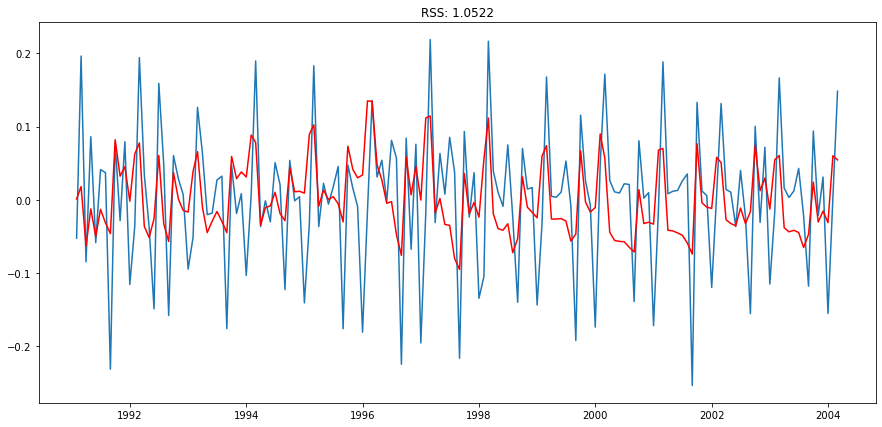

In [40]:
#ARIMA model
model = ARIMA(ts_log, order=(1,1,1))
results_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(15,7))
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues - ts_log_diff)**2))

# <u><b>FINAL STEP: BRINGING THIS BACK TO THE ORIGINAL SCALE</b></u>
###First get the predicted values and store it as series.

In [41]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy = True)
print(predictions_ARIMA_diff.head())

Month
1991-02-01    0.000827
1991-03-01    0.017932
1991-04-01   -0.063581
1991-05-01   -0.012659
1991-06-01   -0.050487
dtype: float64


###Now convert differencing to log scale: find the cumulative sum and add it to a new series with a base value

In [42]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index = ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value = 0)
print(predictions_ARIMA_log.head())

Month
1991-01-01    7.443664
1991-02-01    7.444491
1991-03-01    7.462423
1991-04-01    7.398842
1991-05-01    7.386183
dtype: float64


In [47]:
predictions_ARIMA_log

Month
1991-01-01    7.443664
1991-02-01    7.444491
1991-03-01    7.462423
1991-04-01    7.398842
1991-05-01    7.386183
                ...   
2003-11-01    7.554915
2003-12-01    7.539243
2004-01-01    7.507691
2004-02-01    7.567792
2004-03-01    7.622143
Length: 159, dtype: float64

In [46]:
pd.Series(ts_log.iloc[0], index = ts_log.index)

Month
1991-01-01    7.443664
1991-02-01    7.443664
1991-03-01    7.443664
1991-04-01    7.443664
1991-05-01    7.443664
                ...   
2003-11-01    7.443664
2003-12-01    7.443664
2004-01-01    7.443664
2004-02-01    7.443664
2004-03-01    7.443664
Length: 159, dtype: float64

###Next -take the exponent of the series from above (anti-log) which will be the predicted value — the time series forecast model.

Text(0.5, 1.0, 'RMSE: 1312.9363')

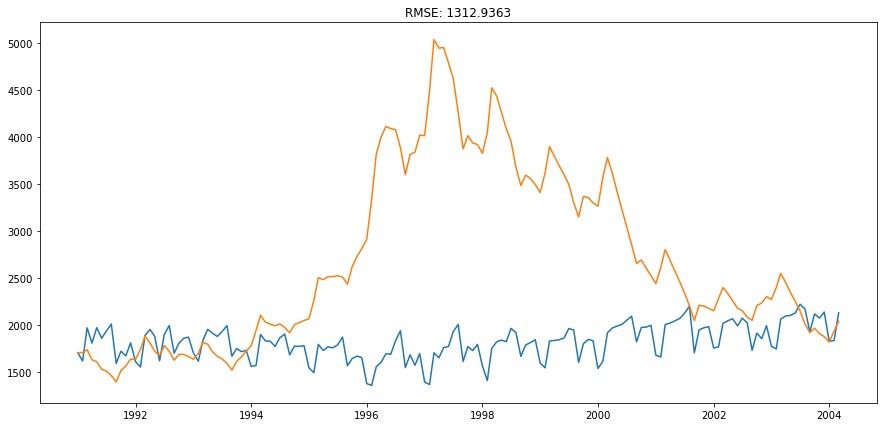

In [43]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.figure(figsize=(15,7))
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA - ts)**2)/len(ts)))

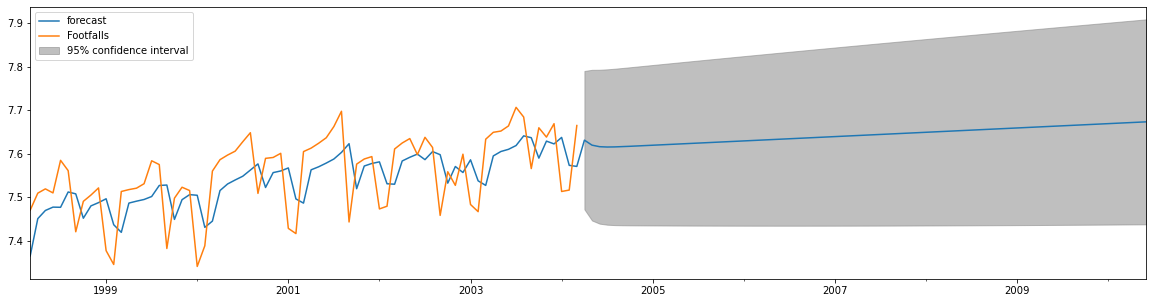

In [44]:
fig, ax = plt.subplots(figsize=(20,5))
fig = results_ARIMA.plot_predict(start='1998-03-01', end='2010-06-01',ax=ax)
legend = ax.legend(loc='upper left')
plt.show()

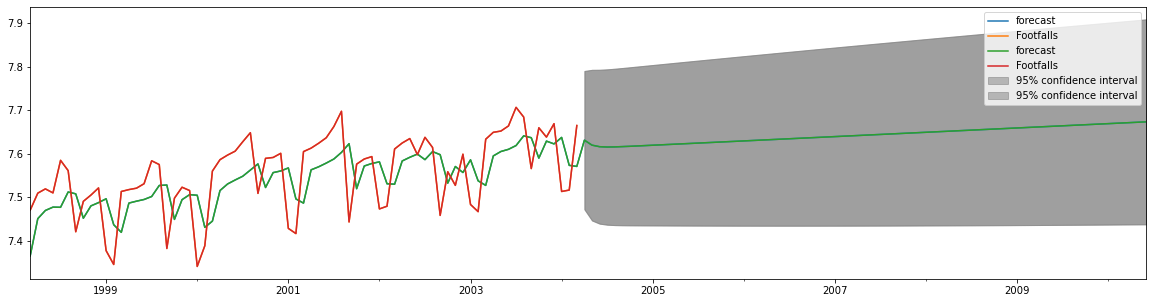

In [49]:
 results_ARIMA.plot_predict(start='1998-03-01', end='2010-06-01',ax=ax)